# Modeling

*prose* does not implement a modeling framework, many options are currently available in python. However, it features some tools to aid in selecting the right model, mainly linear ones.

In this tutorial we will review some of these tools and show how the prose products can conveniently be used within `exoplanet`, itself using the `pymc3` inference framework.

## Making up some data

As usual we will work on simulated data. Here we propose to analyse a planetary transit light curve in which we added some instrumental signals:

INFO Could not convert time to BJD TDB


(0.98, 1.02)

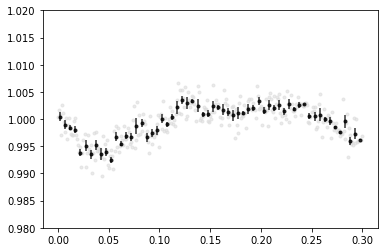

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from prose.simulations import observation_to_model

np.random.seed(37)

time = np.linspace(0, 0.3, 300)
obs = observation_to_model(time)
obs.plot()
plt.ylim(0.98, 1.02)

## Linear models

### Polynomial systematics

It is common to model the instrumental signals using a linear model involving some systematic measurements. Let's say that we measured vector $\boldsymbol{x}$ along time. If $\boldsymbol{f}$ is our measured flux sampled along the same time, we can suppose that it can be modeled as a polynomial order 3 of $\boldsymbol{x}$ plus some **gaussian** noise, so that:

$$\boldsymbol{f} = a\boldsymbol{x}^2 + b\boldsymbol{x} +  c + \boldsymbol{\epsilon}$$

$a$, $b$, $c$ being free parameters. This can be writen in the matrix form:

$$\boldsymbol{f} =
\begin{pmatrix}a & b & c\end{pmatrix}
\begin{pmatrix} \boldsymbol{\phantom{,}x^2}\\\boldsymbol{x}\\\boldsymbol{1}\end{pmatrix} = 
wX$$

with $X$ the *design matrix*. $X$ is known so that this linear equation can be solved for $w$ through ordinary least square. Before doing any of that let's make sure our observation is clean

In [33]:
# removing obvious outlier
obs = obs.sigma_clip()

We can now use *prose* methods to build a linear model by defining its *design matrix*

(0.98, 1.02)

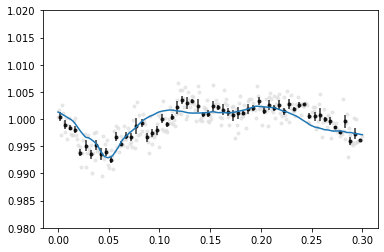

In [34]:
from prose import models
import matplotlib.pyplot as plt

dm = models.design_matrix([
    models.constant(obs.time),
    models.polynomial(obs.sky, 3)
])

trend = obs.trend(dm)

obs.plot()
plt.plot(obs.time, trend)
plt.ylim(0.98, 1.02)

### Adding a transit

Our data contains a transit signal which, at first order, can be modeled as a scaled transit of unitary depth. To do that we will add this template to our design matrix. Here, we will use the more conveniant `Observation.polynomial()` method which comes handy for more complex models.

In [35]:
import numpy as np

t0 = 0.1
duration = 0.03

dm = np.hstack([
    obs.polynomial(sky=1, dy=1),
    obs.transit(t0, duration)
])

# Notice the use of split to get the transit model
trend, transit = obs.trend(dm, split=-1)

Let's do a nice plot

Text(0.0, 1.0, 'detrended')

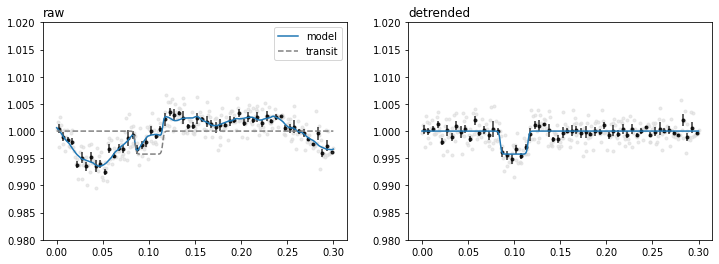

In [36]:
from prose import viz
plt.figure(figsize=(12,4))

plt.subplot(121)
obs.plot()
plt.plot(obs.time, transit + trend, label="model")
plt.plot(obs.time, transit + 1., "--", color="0.5", label="transit")
plt.ylim(0.98, 1.02)
plt.title("raw", loc="left")
plt.legend()

plt.subplot(122)
viz.plot_lc(obs.time, obs.flux - trend + 1.)
plt.plot(obs.time, transit + 1., label="transit")
plt.ylim(0.98, 1.02)
plt.title("detrended", loc="left")

### Using the BIC

We used an arbitrary model. To choose a bit more "wisely" we could use the AIC or BIC. Here we will iterate on a range of possible polynomial order combinations and compute which one gives the best BIC:

> TO DO

This combination can be used within the next step when we doing a fully bayesian modeling of our data with `exoplanet`

## Bayesian modeling

> TO DO